# sPLS (sparse Partial Least Square)

Knowing everything about PLS, modifying it to obtain sPLS is not a big deal. We just need to add an $\ell_1$ penalization to the optimization problem seen before.

Let $z = X^T y$. From the standard PLS problem:

$$
\max_w \left( \text{Cov}(Xw, y) \right)^2 \quad \text{subject to} \quad \|w\|_2 = 1
$$

We get the **sPLS** formulation:

$$
\max_w \left( \text{Cov}(Xw, y) \right)^2 \quad \text{subject to} \quad \|w\|_2 = 1 \quad  \& \quad \|w\|_1 \leq \lambda
$$

### Lagrangian formulation

We introduce Lagrange multipliers $\mu_0$ (for the inequality constraint) and $\mu_1$ (for the equality constraint). We use $\|w\|_2^2$ to simplify derivatives.

$$
\mathcal{L}(w, \mu_0, \mu_1) = -w^Tz + \mu_0(\|w\|_1 - \lambda) + \mu_1(\|w\|_2^2 - 1)
$$

The Karush-Kuhn-Tucker (KKT) conditions for optimality are:

$$
\begin{cases}
-z + \mu_0 u + 2\mu_1 w = 0  \\
\|w\|_1 \leq \lambda  \\
\|w\|_2^2 = 1 \\
\mu_0 \geq 0  \\
\mu_0(\|w\|_1 - \lambda) = 0
\end{cases}
$$

Where $u$ is the **sub-gradient** of the $\ell_1$ norm ($\partial \|w\|_1$). Its components $u_i$ are defined as:
*   $u_i = \text{sign}(w_i)$ if $w_i \neq 0$
*   $u_i \in [-1, 1]$ if $w_i = 0$

From the stationarity equation, we can isolate $w_i$:
$$ 2\mu_1 w_i = z_i - \mu_0 u_i $$

---

### Case 1: $\mu_0 = 0$
The constraint $\|w\|_1 \le \lambda$ is not active (the solution is naturally inside the $\ell_1$ ball).
Equation becomes $2\mu_1 w = z$.

$$
 w = \frac{z}{\|z\|_2} \quad \text{provided that } \|z\|_1 \leq \lambda \|z\|_2
$$

---

### Case 2: $\mu_0 > 0$
The solution hits the boundary, so $\|w\|_1 = \lambda$.
We must solve $2\mu_1 w_i = z_i - \mu_0 u_i$.

**1. Sign Consistency**
First, we observe that $w_i$ and $z_i$ must have the same sign (or $w_i=0$).
*   If $w_i > 0$, then $u_i = 1$. The equation is $2\mu_1 w_i = z_i - \mu_0$. Since $\mu_0, \mu_1, w_i$ are positive, $z_i$ must be positive.
*   The same logic applies for negative values.
*   Therefore, $u_i = \text{sign}(w_i) = \text{sign}(z_i)$ for non-zero components.

**2. Condition for Sparsity ($w_i = 0$)**
When does a coefficient vanish?
If we assume $w_i = 0$, the sub-gradient definition tells us that $u_i$ can be any value in $[-1, 1]$.
The stationarity equation becomes:
$$ 0 = z_i - \mu_0 u_i \iff z_i = \mu_0 u_i $$
Since $|u_i| \le 1$, this equality holds **if and only if** $|z_i| \le \mu_0$.

> **Insight:** If the signal correlation $z_i$ is lower than the noise threshold $\mu_0$, the coefficient $w_i$ is forced to 0.

**3. The Soft-Thresholding Solution**
Combining the sign consistency and the sparsity condition, we have two situations:
*   **If $|z_i| \le \mu_0$**: $w_i = 0$.
*   **If $|z_i| > \mu_0$**: The term $\mu_0 u_i$ acts as a penalty that reduces the magnitude of $z_i$.
    $$ 2\mu_1 w_i = z_i - \mu_0 \text{sign}(z_i) = \text{sign}(z_i)(|z_i| - \mu_0) $$

We can merge these two cases using the **positive part part operator** $(x)_+ = \max(0, x)$. This formulation automatically handles the zeroing of coefficients:

$$
w_i = \frac{1}{2\mu_1} \text{sign}(z_i) (|z_i| - \mu_0)_+
$$

Finally, since we require $\|w\|_2 = 1$, the vector $w$ is simply the normalized version of this soft-thresholded covariance vector.


## Implementation

In [9]:
# Fonction utilitaire nécessaire pour alléger le code modifié. de PLS
import numpy as np

def soft_thresholding(z, mu_0):
    """
    Applique l'opérateur de seuillage doux (soft-thresholding).
    z : vecteur à seuiller (ici X.T @ y)
    mu_0 : paramètre de pénalité (threshold). Plus il est grand, plus le vecteur est 'sparse'.
    """
    # On calcule |z| - mu_0
    diff = np.abs(z) - mu_0
    
    # On applique la partie positive (max(0, ...))
    diff_positive = np.maximum(diff, 0)
    
    # On remet le signe et on retourne
    return np.sign(z) * diff_positive


In [ ]:
def base_sPLS(E, F, mu_0):
    if F.ndim == 1:
        """In the case of a $y$ with a single column, it is not useful to use the algorithm
        as we have an analytic answer to the problem."""   
        F = F.reshape(-1, 1)

        # --- MODIF sPLS ---
        z = np.transpose(E) @ F         # Calcul de la covariance brute
        w = soft_thresholding(z, mu_0)  # Application du seuillage
        # ------------------

        # Sécurité pour éviter la division par 0 si mu_0 est trop grand
        if np.linalg.norm(w) == 0: w[0] = 1.0 

        w = w/np.linalg.norm(w, ord=2) # normalization to gauarantee ||w|| = 1

        t = E @ w

        c = np.transpose(F) @ t
        c = c / np.linalg.norm(c) # normalization
    else: 
        """Else, we need to use the PLS2 algorithm to estimate a solution. 
        """

        u = np.random.rand(E.shape[0]) # Initialize u with random values
        u = u.reshape(-1, 1) # Reshape for coherence in matrixes shapes

        for k in range(10): # To be changed with a real stop condition
            # Step 1: estimate X weights
            # --- MODIF sPLS ---
            z = np.transpose(E) @ u        # Covariance entre X et le score u courant
            w = soft_thresholding(z, mu_0) # Application du seuillage
            # ------------------
            
            # Sécurité division par 0
            if np.linalg.norm(w) == 0: 
                w[np.argmax(np.abs(z))] = 1.0 # Fallback simple


            w = w/np.linalg.norm(w, ord=2) # normalization

            # Step 2: Estimate t, the factor scores
            t = E @ w

            # Step 3: Estimate c (y weights)
            c = np.transpose(F) @ t
            c = c / np.linalg.norm(c) # normalization

            # Step 4: Estimate $y$ scores
            u = F @ c
        
    return w, t, c

## Experiment

In [11]:
def sPLS(E, F, n_components=3, mu_0=0.0):
    """
    sPLS Main Algorithm.
    mu_0: Sparsity parameter (Thresholding value). 
          if mu_0 = 0, this is a standard PLS.
          if mu_0 > 0, weights w will be sparse.
    """
    E = E.copy()
    F = F.copy()

    if F.ndim == 1:
        F = F.reshape(-1, 1)

    # Initializations
    WW = np.zeros((E.shape[1], n_components)) # W: X weights
    TT = np.zeros((E.shape[0], n_components)) # T: X scores
    PP = np.zeros((E.shape[1], n_components)) # P: X loadings
    QQ = np.zeros((F.shape[1], n_components)) # Q: y loadings

    for k in range(n_components):
        # Step 1: Base sPLS (calling the function defined above)
        w, t, c = base_sPLS(E, F, mu_0=mu_0)

        # Store results
        WW[:, k], TT[:, k] = w.reshape(-1), t.reshape(-1)

        # Step 2: Regression to find loadings p and q
        # p = (E^T t) / (t^T t)
        p = (E.T @ t) / (t.T @ t)
        PP[:, k] = p.reshape(-1)

        q = (F.T @ t) / (t.T @ t) 
        QQ[:, k] = q.reshape(-1)

        # Step 3: Deflation
        E = E - t @ p.T 
        F = F - t @ c.T 

    # Compute Beta (Regression coefficients)
    # Beta maps X to y directly: y_hat = X @ Beta
    rotation_matrix = WW @ np.linalg.pinv(PP.T @ WW)
    beta = rotation_matrix @ QQ.T

    return {
        "beta": beta,               
        "weights_W": WW,             
        "scores_T": TT
    }

####################################################################################################
####################################################################################################
Applying sPLS with mu_0 = 124.40


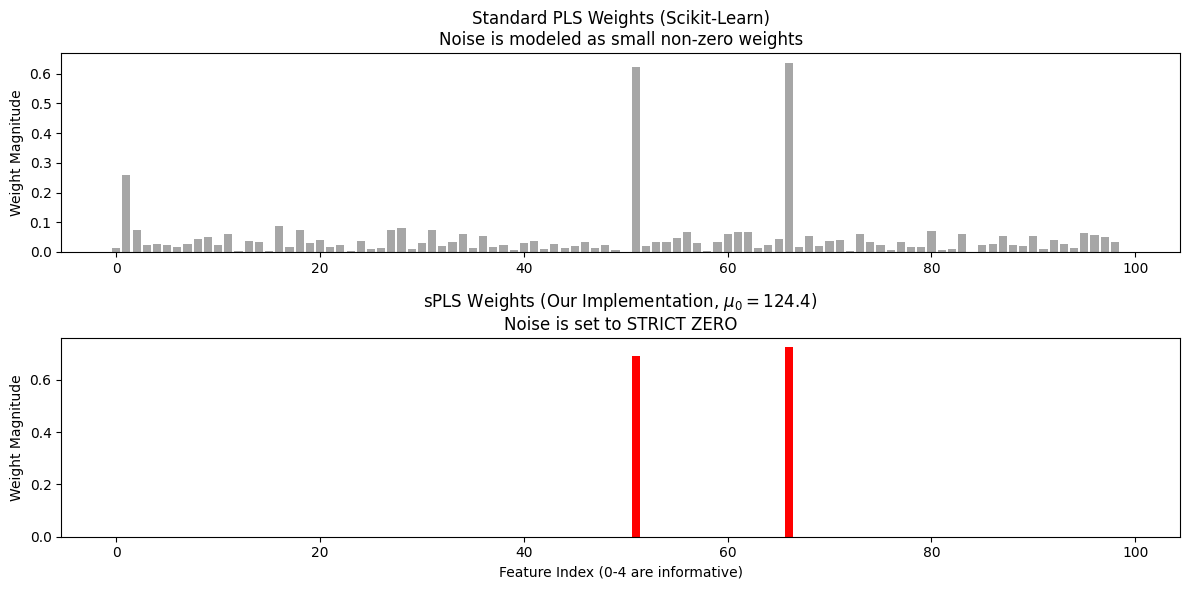

Number of features set to zero by Scikit-Learn: 0 / 100
Number of features set to zero by our sPLS:     98 / 100
####################################################################################################
####################################################################################################
Applying sPLS with mu_0 = 62.20


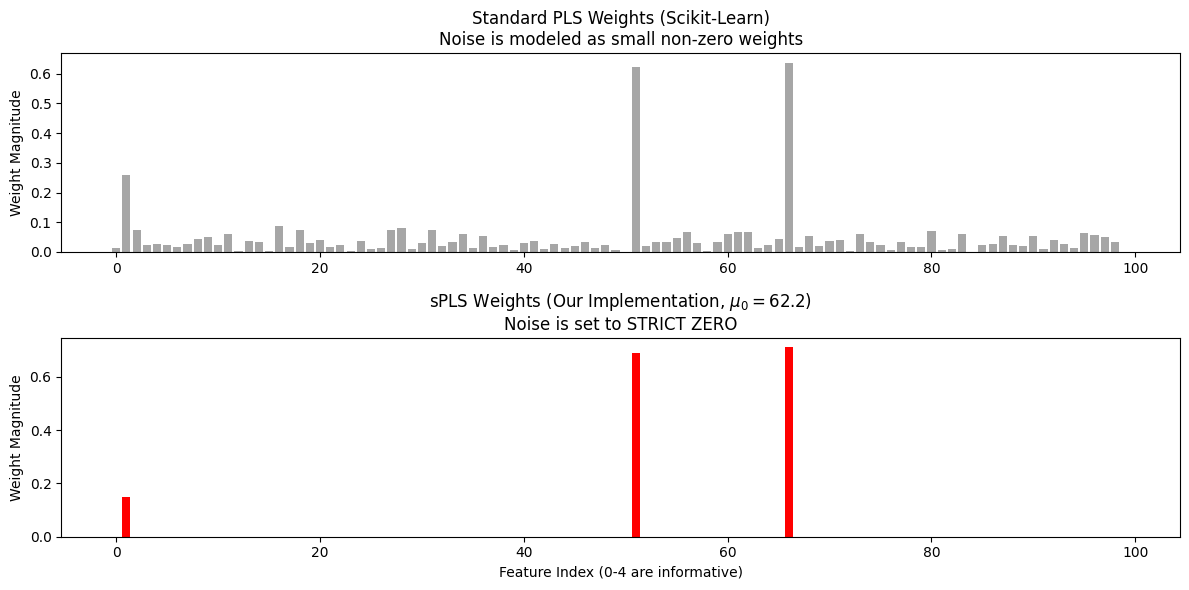

Number of features set to zero by Scikit-Learn: 0 / 100
Number of features set to zero by our sPLS:     97 / 100
####################################################################################################
####################################################################################################
Applying sPLS with mu_0 = 31.10


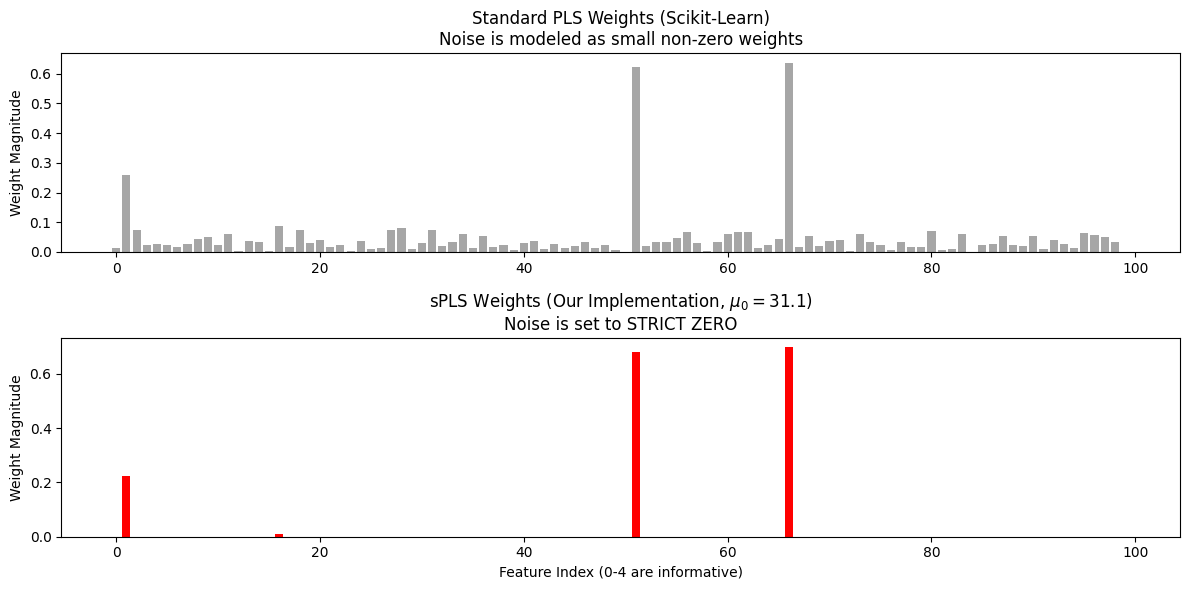

Number of features set to zero by Scikit-Learn: 0 / 100
Number of features set to zero by our sPLS:     95 / 100
####################################################################################################
####################################################################################################
Applying sPLS with mu_0 = 15.55


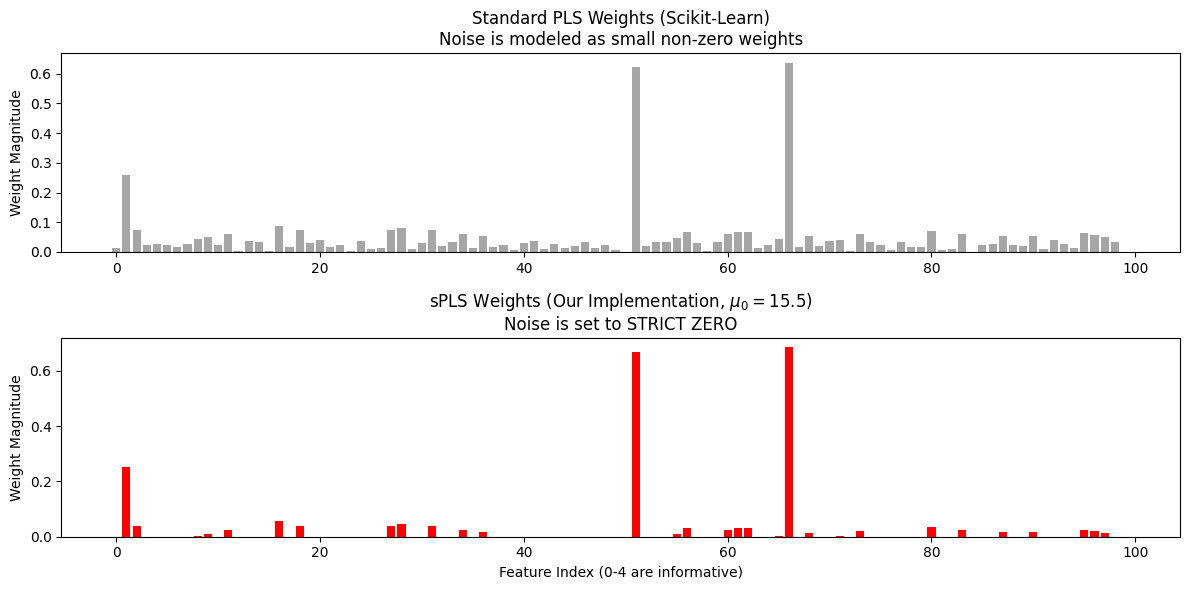

Number of features set to zero by Scikit-Learn: 0 / 100
Number of features set to zero by our sPLS:     69 / 100


In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.cross_decomposition import PLSRegression

def z_score_standardize(M):
    """Standardize a dataset matrix computing means and stds on columns

    Args:
        M (np.array): 2D-matrix

    Returns:
        np.array: standardized 2D-matrix
    """
    means = np.mean(M, axis=0)
    stds = np.std(M, axis=0)

    return (M - means) / stds


########################################################################
# Coded by @gemini for fast testing
########################################################################
# 1. Generate Synthetic Data
# 100 features, but only 5 are effective. 95 are noise.
n_features = 100
n_informative = 5
X_sim, y_sim = make_regression(n_samples=500, n_features=n_features, 
                               n_informative=n_informative, noise=0.5, random_state=42)

# Standardize (Crucial for PLS)
X_sim, X_test_sim, y_sim, y_test_sim = train_test_split(X_sim, y_sim, test_size=0.3, random_state=42)
X_sim = z_score_standardize(X_sim)
y_sim = z_score_standardize(y_sim.reshape(-1, 1))

# --- MODEL 1: Scikit-Learn PLS (No sparsity) ---
pls_sklearn = PLSRegression(n_components=1)
pls_sklearn.fit(X_sim, y_sim)
w_sklearn = pls_sklearn.x_weights_.flatten()

# --- MODEL 2: Our sPLS (With sparsity) ---
# Heuristic for mu_0: We want to threshold low covariances.
# Let's try to cut values below half the max covariance.
initial_covariance = np.dot(X_sim.T, y_sim)
mu_heuristic = 0.5 * np.max(np.abs(initial_covariance))

for mu_0 in [mu_heuristic, mu_heuristic/2, mu_heuristic/4, mu_heuristic/8]:
    print("#"*100)
    print("#"*100)
    print(f"Applying sPLS with mu_0 = {mu_0:.2f}")

    res_spls = sPLS(X_sim, y_sim, n_components=1, mu_0=mu_0)
    w_spls = res_spls["weights_W"][:, 0]

    # --- Visualization ---
    plt.figure(figsize=(12, 6))

    # Plot Sklearn Weights
    plt.subplot(2, 1, 1)
    plt.bar(range(n_features), np.abs(w_sklearn), color='gray', alpha=0.7)
    plt.title("Standard PLS Weights (Scikit-Learn)\nNoise is modeled as small non-zero weights")
    plt.ylabel("Weight Magnitude")

    # Plot sPLS Weights
    plt.subplot(2, 1, 2)
    # Highlight non-zero weights in red, zeros in blue
    colors = ['red' if w != 0 else 'blue' for w in w_spls]
    plt.bar(range(n_features), np.abs(w_spls), color=colors)
    plt.title(f"sPLS Weights (Our Implementation, $\mu_0={mu_0:.1f}$)\nNoise is set to STRICT ZERO")
    plt.xlabel("Feature Index (0-4 are informative)")
    plt.ylabel("Weight Magnitude")

    plt.tight_layout()
    plt.show()

    # --- Quantitative verification ---
    zeros_sklearn = np.sum(np.abs(w_sklearn) < 1e-10)
    zeros_spls =    np.sum(np.abs(w_spls) == 0)

    print(f"Number of features set to zero by Scikit-Learn: {zeros_sklearn} / 100")
    print(f"Number of features set to zero by our sPLS:     {zeros_spls} / 100")

